In [1]:
from google.colab import drive

In [2]:
import os
import requests
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pathlib import Path
import json
# from decouple import AutoConfig
# from langdetect import detect
import time
import sqlite3
import bs4 as bs

In [ ]:
config = AutoConfig(search_path=os.getcwd())

In [3]:
class Init():
    """Class that initializes global value for the module. It also use general method to initialize value."""

    def __init__(self):
        """Built-in method to inialize the global values for the module
        Attributes
        -----------
        `self.start.date` : str
            start date of the training period. Must be within the last year for the free version of FinHub. Format
            must be "YYYY-mm-dd"
        `self.end_date` : str
            end date of the training period. Format must be "YYYY-mm-dd"
        `self.ticker` : list
            tickers on which we want to perform the test. Can be one ticker in form of a list as well as a list
            of tickers like the s&p 500.
        `self.db_name` : str
            name of the sqlite3 database
        `self.dir_path` : str
            directory where the data are saved. It takes into account the `self.start_date` and `self.end_date`
        `self.start_date_` : datetime object
            same thing as `start_date` but as a datetime object
        `self.end_date_` : datetime object
            same thing as `start_date` but as a datetime object
        """

        #initialize value here
        self.start_date = "2022-07-25"
        self.end_date = "2023-07-17"
        self.tickers = ['AAPL', 'META', 'AMZN', 'NFLX', 'GOOG']

        self.db_name = 'financial_data'
        self.dir_path = os.path.realpath('') + '/output/' + self.start_date + '_' + self.end_date + '/'
        Path(self.dir_path).mkdir(parents=True, exist_ok=True) #create new path if it doesn't exist
        self.start_date_ = datetime.strptime(self.start_date, "%Y-%m-%d")  #datetime object
        self.end_date_ = datetime.strptime(self.end_date, "%Y-%m-%d")    #datetime object
        self.delta_date = abs((self.end_date_ - self.start_date_).days) #number of days between 2 dates


        try:
            self.start_date_ > self.end_date_
        except:
            print("'start_date' is after 'end_date'")

        t = (datetime.now()- relativedelta(years=1))
        d= datetime.strptime(self.start_date, "%Y-%m-%d")

        if (datetime.strptime(self.start_date, "%Y-%m-%d") <= (datetime.now()- relativedelta(years=1))) :
            raise Exception("'start_date' is older than 1 year. It doesn't work with the free version of FinHub")

In [ ]:
class FinnHub():

    def __init__(self,start_date,end_date,start_date_,end_date_,tickers,dir_path,db_name):

        self.max_call = 60
        self.time_sleep = 60
        self.nb_request = 0
        self.finhub_key = config('FINHUB_KEY')
        self.news_header = ['category', 'datetime','headline','id','image','related','source','summary','url']
        self.start_date = start_date
        self.end_date = end_date
        self.tickers = tickers
        self.ticker_request = tickers

        self.dir_path = dir_path
        self.db_name = db_name
        self.js_data = []

        self.start_date_ = start_date_
        self.end_date_ = end_date_

        for ticker_ in self.tickers:
            self.js_data.clear()
            self.ticker = ticker_ + '_'
            self.ticker_request = ticker_
            self.req_new()
            self.create_table()
            self.clean_table()
            self.lang_review()

    def init_sql(func):

        def wrapper_(self):
            conn_ = sqlite3.connect(self.dir_path + self.db_name + '.db')
            c = conn_.cursor()
            func(self,conn_,c)
            conn_.commit()
            conn_.close()
        return wrapper_

    @init_sql
    def clean_table(self,conn_,c):

        #remove NULL entry (row) from headline column
        c.execute(f" DELETE FROM {self.ticker} WHERE {self.news_header[2]} IS NULL OR "
                  f"trim({self.news_header[2]}) = '';")
        # remove NULL value from datetime
        c.execute(f" DELETE FROM {self.ticker} WHERE {self.news_header[1]} IS NULL OR "
                  f"trim({self.news_header[1]}) = '';")

        #removes duplicate entries (row)
        c.execute(f" DELETE FROM {self.ticker} WHERE rowid NOT IN (select MIN(rowid)"
                  f"FROM {self.ticker} GROUP BY {self.news_header[2]})")

    @init_sql
    def create_table(self,conn_,c):

        #create table if it does not exist
        c.execute(f'drop table if exists {self.ticker}')
        conn_.commit()
        c.execute(f"CREATE TABLE IF NOT EXISTS {self.ticker} ({self.news_header[0]})")
        conn_.commit()

        #add columns to the table if the columns don't exist
        for header_ in range(len(self.news_header)-1):
            c.execute(f"alter table {self.ticker} add column '%s' " % self.news_header[header_+1])
            conn_.commit()

        iteration = 0
        for data_ in self.js_data:
            iteration +=1
            try :
                c.execute(f'insert into {self.ticker} values (?,?,?,?,?,?,?,?,?)',[data_[self.news_header[0]],
                          data_[self.news_header[1]],data_[self.news_header[2]],data_[self.news_header[3]],
                        data_[self.news_header[4]],data_[self.news_header[5]],data_[self.news_header[6]],
                          data_[self.news_header[7]],data_[self.news_header[8]]])
            except:
                print(f"Error at the {iteration}th ieration")

            conn_.commit()

    def iterate_day(func):

        def wrapper_(self):
            delta_date_ = delta_date(self.start_date,self.end_date)
            date_ = self.start_date
            date_obj = self.start_date_

            for item in range(delta_date_ + 1):
                self.nb_request +=1
                func(self,date_)
                date_obj = date_obj + relativedelta(days=1)
                date_  = date_obj.strftime("%Y-%m-%d")
                if self.nb_request == (self.max_call-1):
                    time.sleep(self.time_sleep)
                    self.nb_request=0
        return wrapper_

    @init_sql
    def lang_review(self,conn_,c):

        list_ = []
        c.execute(f" SELECT {self.news_header[2]} FROM {self.ticker}")

        #check for non-english headlines
        for item_ in c:
            if detect(item_[0]) != 'en':
                list_.append(item_[0])

        #delete non-english entries (rows)
            query = f"DELETE FROM {self.ticker} where {self.news_header[2]} in ({','.join(['?']*len(list_))})"
            c.execute(query, list_)

    @iterate_day
    def req_new(self,date_):

        request_ = requests.get('https://finnhub.io/api/v1/company-news?symbol=' + self.ticker_request + '&from=' +
                                date_ + '&to=' + date_ + '&token=' + self.finhub_key)
        self.js_data += request_.json()

In [4]:
init_ = Init()
init_.tickers

['AAPL', 'META', 'AMZN', 'NFLX', 'GOOG']

In [ ]:
finhub = FinnHub(start_date=init_.start_date, end_date=init_.end_date,start_date_=init_.start_date_ ,
                end_date_ =init_.end_date_, tickers=init_.tickers, dir_path =init_.dir_path,db_name=init_.db_name)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls '/content/drive/My Drive/output'

2022-07-25_2023-07-17  2022-09-29_2023-05-29
2022-09-22_2023-05-22  2023-05-22_2023-05-23


In [7]:
conn = sqlite3.connect(r'/content/drive/My Drive/output/{0}_{1}/financial_data.db'.format(init_.start_date, init_.end_date))
cur = conn.cursor()

In [8]:
sql_query = """SELECT name FROM sqlite_master
  WHERE type='table';"""
cur.execute(sql_query)
print(cur.fetchall())

[('AAPL_',), ('META_',), ('AMZN_',), ('NFLX_',), ('GOOG_',)]


In [9]:
%%time

i = 0

for ticker in init_.tickers:
    conn = sqlite3.connect(r'/content/drive/My Drive/output/{0}_{1}/financial_data.db'.format(init_.start_date, init_.end_date))
    cur = conn.cursor()

#     cur.execute("SELECT count(*) FROM {}_;".format(ticker))
#     one_result = cur.fetchone()
#     print(one_result)

    df_tick = pd.read_sql("select * from {}_".format(ticker), conn)
    df_tick['dt'] = pd.to_datetime(df_tick['datetime'],unit='s')


    if i < 1:
        all_data = df_tick.copy()
    else: all_data = pd.concat([all_data, df_tick])

    i += 1

all_data.reset_index(drop= True , inplace= True )

CPU times: user 250 ms, sys: 50.7 ms, total: 301 ms
Wall time: 393 ms


In [10]:
all_data['len_summary'] = all_data['summary'].map(lambda x: len(x.split(' ')))

In [11]:
all_data = all_data[all_data['len_summary'] < 251] # дроп 19 строк

In [12]:
len(all_data) #45474

45455

In [13]:
all_data.reset_index(drop= True , inplace= True )

In [14]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.0 MB/s eta 0:00:00


In [15]:
!pip install xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.5 MB/s eta 0:00:00


In [16]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

In [17]:
model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis", max_length=512, truncation=True, padding='max_length')

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device='cuda')

sentences = ["Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales.",
             "Bids or offers include at least 1,000 shares and the value of the shares must correspond to at least EUR 4,000.",
             "Raute reported a loss per share of EUR 0.86 for the first half of 2009 , against EPS of EUR 0.74 in the corresponding period of 2008.",
             ]
results = nlp(sentences)
print(results)

[{'label': 'positive', 'score': 0.9998133778572083}, {'label': 'neutral', 'score': 0.9997822642326355}, {'label': 'negative', 'score': 0.9877365231513977}]


In [22]:
for i in all_data['headline'][:10]:
    print(nlp(i)[0]['label'])

neutral
positive
negative
neutral
neutral
neutral
negative
neutral
neutral
positive


In [19]:
all_data

,category,datetime,headline,id,image,related,source,summary,url,dt,len_summary
0,company,1658793420,A 3-Day Tech Earnings Deluge Begins. Here Are ...,114354098,https://s.yimg.com/ny/api/res/1.2/CUnz5ASOWXez...,AAPL,Yahoo,"Microsoft, Meta, Apple, Amazon, Alphabet, Inte...",https://finnhub.io/api/news?id=fe6aba02963e78f...,2022-07-25 23:57:00,17
1,company,1658789577,"Taiwan Q2 GDP to gain from chip exports, but f...",114354783,,AAPL,Finnhub,Taiwan's trade-reliant economy is expected to ...,https://finnhub.io/api/news?id=7cef6789ac05e24...,2022-07-25 22:52:57,35
2,company,1658789093,"Stocks wobble on Walmart warning, looming Fed ...",114354816,,AAPL,Finnhub,Asian shares wobbled on Tuesday and bonds were...,https://finnhub.io/api/news?id=49974484dc2bb47...,2022-07-25 22:44:53,38
3,company,1658783580,Snap Stock Nets Yet Another Downgrade. TikTok ...,114354314,https://s.yimg.com/ny/api/res/1.2/tST_aMhdHYyx...,AAPL,Yahoo,"Shares of the company, the parent of the socia...",https://finnhub.io/api/news?id=69618b0afdb5d44...,2022-07-25 21:13:00,17
4,company,1658783508,NFL+ streaming service launches for $4.99 per ...,114354315,https://s.yimg.com/ny/api/res/1.2/t2Gja41wNOPQ...,AAPL,Yahoo,Yahoo Finance's Josh Schafer joins the Live sh...,https://finnhub.io/api/news?id=b1e0d5d26a67ae0...,2022-07-25 21:11:48,28
...,...,...,...,...,...,...,...,...,...,...,...
45450,company,1689570000,Leaven Partners Second Quarter 2023 Letter To ...,121421141,https://static.seekingalpha.com/cdn/s3/uploads...,GOOG,SeekingAlpha,"In the second quarter of 2023, fund assets app...",https://finnhub.io/api/news?id=0e1b0bd6369e490...,2023-07-17 05:00:00,19
45451,company,1689567540,"Steven Romick Cuts Back Alphabet Stakes, Adds ...",121436572,,GOOG,GuruFocus,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=2885646f9df823e...,2023-07-17 04:19:00,21
45452,company,1689563645,"We see rates fall later this year, which could...",121425638,https://image.cnbcfm.com/api/v1/image/10727219...,GOOG,CNBC,"Jimmy Lee, CEO of Wealth Consulting Group, exp...",https://finnhub.io/api/news?id=cfe9f391b05571a...,2023-07-17 03:14:05,28
45453,company,1689560340,"Dear NVDA Stock Fans, Mark Your Calendars for ...",121435726,,GOOG,InvestorPlace,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=d1a1d4722878459...,2023-07-17 02:19:00,21


In [24]:
from tqdm import tqdm

tqdm.pandas()

all_data['label_summary'] = all_data['summary'].progress_apply(lambda x: nlp(x)[0]['label'])

  0%|          | 0/45455 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 45455/45455 [10:37<00:00, 71.31it/s]


In [28]:
all_data.tail()

,category,datetime,headline,id,image,related,source,summary,url,dt,len_summary,label_summary
45450,company,1689570000,Leaven Partners Second Quarter 2023 Letter To ...,121421141,https://static.seekingalpha.com/cdn/s3/uploads...,GOOG,SeekingAlpha,"In the second quarter of 2023, fund assets app...",https://finnhub.io/api/news?id=0e1b0bd6369e490...,2023-07-17 05:00:00,19,positive
45451,company,1689567540,"Steven Romick Cuts Back Alphabet Stakes, Adds ...",121436572,,GOOG,GuruFocus,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=2885646f9df823e...,2023-07-17 04:19:00,21,neutral
45452,company,1689563645,"We see rates fall later this year, which could...",121425638,https://image.cnbcfm.com/api/v1/image/10727219...,GOOG,CNBC,"Jimmy Lee, CEO of Wealth Consulting Group, exp...",https://finnhub.io/api/news?id=cfe9f391b05571a...,2023-07-17 03:14:05,28,neutral
45453,company,1689560340,"Dear NVDA Stock Fans, Mark Your Calendars for ...",121435726,,GOOG,InvestorPlace,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=d1a1d4722878459...,2023-07-17 02:19:00,21,neutral
45454,company,1689558420,Alibaba Is Set for a Resurgence Through Push I...,121430610,,GOOG,GuruFocus,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=86eed1d072440a1...,2023-07-17 01:47:00,21,neutral


In [27]:
all_data['label_summary'].value_counts()

neutral     28001
positive    11213
negative     6241
Name: label_summary, dtype: int64

In [36]:
all_data = all_data[all_data['dt'] >= '{}'.format(init_.start_date)]
all_data

,category,datetime,headline,id,image,related,source,summary,url,dt,len_summary,label_summary
0,company,1658793420,A 3-Day Tech Earnings Deluge Begins. Here Are ...,114354098,https://s.yimg.com/ny/api/res/1.2/CUnz5ASOWXez...,AAPL,Yahoo,"Microsoft, Meta, Apple, Amazon, Alphabet, Inte...",https://finnhub.io/api/news?id=fe6aba02963e78f...,2022-07-25 23:57:00,17,neutral
1,company,1658789577,"Taiwan Q2 GDP to gain from chip exports, but f...",114354783,,AAPL,Finnhub,Taiwan's trade-reliant economy is expected to ...,https://finnhub.io/api/news?id=7cef6789ac05e24...,2022-07-25 22:52:57,35,positive
2,company,1658789093,"Stocks wobble on Walmart warning, looming Fed ...",114354816,,AAPL,Finnhub,Asian shares wobbled on Tuesday and bonds were...,https://finnhub.io/api/news?id=49974484dc2bb47...,2022-07-25 22:44:53,38,negative
3,company,1658783580,Snap Stock Nets Yet Another Downgrade. TikTok ...,114354314,https://s.yimg.com/ny/api/res/1.2/tST_aMhdHYyx...,AAPL,Yahoo,"Shares of the company, the parent of the socia...",https://finnhub.io/api/news?id=69618b0afdb5d44...,2022-07-25 21:13:00,17,negative
4,company,1658783508,NFL+ streaming service launches for $4.99 per ...,114354315,https://s.yimg.com/ny/api/res/1.2/t2Gja41wNOPQ...,AAPL,Yahoo,Yahoo Finance's Josh Schafer joins the Live sh...,https://finnhub.io/api/news?id=b1e0d5d26a67ae0...,2022-07-25 21:11:48,28,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
45450,company,1689570000,Leaven Partners Second Quarter 2023 Letter To ...,121421141,https://static.seekingalpha.com/cdn/s3/uploads...,GOOG,SeekingAlpha,"In the second quarter of 2023, fund assets app...",https://finnhub.io/api/news?id=0e1b0bd6369e490...,2023-07-17 05:00:00,19,positive
45451,company,1689567540,"Steven Romick Cuts Back Alphabet Stakes, Adds ...",121436572,,GOOG,GuruFocus,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=2885646f9df823e...,2023-07-17 04:19:00,21,neutral
45452,company,1689563645,"We see rates fall later this year, which could...",121425638,https://image.cnbcfm.com/api/v1/image/10727219...,GOOG,CNBC,"Jimmy Lee, CEO of Wealth Consulting Group, exp...",https://finnhub.io/api/news?id=cfe9f391b05571a...,2023-07-17 03:14:05,28,neutral
45453,company,1689560340,"Dear NVDA Stock Fans, Mark Your Calendars for ...",121435726,,GOOG,InvestorPlace,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=d1a1d4722878459...,2023-07-17 02:19:00,21,neutral


In [41]:
new_data = all_data[['related', 'dt', 'label_summary']].copy()

new_data['neutral'] = new_data['label_summary'].map(lambda x: 1 if x == 'neutral' else 0)
new_data['positive'] = new_data['label_summary'].map(lambda x: 1 if x == 'positive' else 0)
new_data['negative'] = new_data['label_summary'].map(lambda x: 1 if x == 'negative' else 0)

new_data

,related,dt,label_summary,neutral,positive,negative
0,AAPL,2022-07-25 23:57:00,neutral,1,0,0
1,AAPL,2022-07-25 22:52:57,positive,0,1,0
2,AAPL,2022-07-25 22:44:53,negative,0,0,1
3,AAPL,2022-07-25 21:13:00,negative,0,0,1
4,AAPL,2022-07-25 21:11:48,neutral,1,0,0
...,...,...,...,...,...,...
45450,GOOG,2023-07-17 05:00:00,positive,0,1,0
45451,GOOG,2023-07-17 04:19:00,neutral,1,0,0
45452,GOOG,2023-07-17 03:14:05,neutral,1,0,0
45453,GOOG,2023-07-17 02:19:00,neutral,1,0,0


In [43]:
agg_data = new_data.groupby([
                 pd.Grouper(key="dt", freq="d"),
                 'related'
               ])['neutral', 'positive', 'negative'].sum()

agg_data.head(15)

<ipython-input-43-3933bf68bb02>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  agg_data = new_data.groupby([


neutral  positive  negative
dt         related                             
2022-07-25 AAPL          23        13         5
           AMZN          21        13         6
           GOOG          24         9         5
           META          20         8         8
           NFLX          21         9         7
2022-07-26 AAPL          11        10         6
           AMZN          17         6        12
           GOOG          10        14         6
           META          15         4         7
           NFLX          17         8         5
2022-07-27 AAPL          35         9        22
           AMZN          40        15         8
           GOOG          37        29         9
           META           8         6         8
           NFLX          10        11         3

In [52]:
agg_data['neutral_1'] = agg_data['neutral'].shift(5)
agg_data['positive_1'] = agg_data['positive'].shift(5)
agg_data['negative_1'] = agg_data['negative'].shift(5)

agg_data['neutral_2'] = agg_data['neutral'].shift(10)
agg_data['positive_2'] = agg_data['positive'].shift(10)
agg_data['negative_2'] = agg_data['negative'].shift(10)

agg_data['neutral_3'] = agg_data['neutral'].shift(15)
agg_data['positive_3'] = agg_data['positive'].shift(15)
agg_data['negative_3'] = agg_data['negative'].shift(15)

agg_data['neutral_4'] = agg_data['neutral'].shift(20)
agg_data['positive_4'] = agg_data['positive'].shift(20)
agg_data['negative_4'] = agg_data['negative'].shift(20)

agg_data['neutral_5'] = agg_data['neutral'].shift(25)
agg_data['positive_5'] = agg_data['positive'].shift(25)
agg_data['negative_5'] = agg_data['negative'].shift(25)

agg_data['neutral_6'] = agg_data['neutral'].shift(30)
agg_data['positive_6'] = agg_data['positive'].shift(30)
agg_data['negative_6'] = agg_data['negative'].shift(30)

agg_data.head(35)

neutral  positive  negative  neutral_1  positive_1  \
dt         related                                                       
2022-07-25 AAPL          23        13         5        NaN         NaN   
           AMZN          21        13         6        NaN         NaN   
           GOOG          24         9         5        NaN         NaN   
           META          20         8         8        NaN         NaN   
           NFLX          21         9         7        NaN         NaN   
2022-07-26 AAPL          11        10         6       23.0        13.0   
           AMZN          17         6        12       21.0        13.0   
           GOOG          10        14         6       24.0         9.0   
           META          15         4         7       20.0         8.0   
           NFLX          17         8         5       21.0         9.0   
2022-07-27 AAPL          35         9        22       11.0        10.0   
           AMZN          40        15         8       17.0         6.0   
           GOOG          37        29         9       10.0        14.0   
           META           8         6         8       15.0         4.0   
           NFLX          10        11         3       17.0         8.0   
2022-07-28 AAPL           8        10         8       35.0         9.0   
           AMZN          10         8         6       40.0        15.0   
           GOOG          19         3         9       37.0        29.0   
           META          49        12        18        8.0         6.0   
           NFLX          20         3         5       10.0        11.0   
2022-07-29 AAPL          45        54         7        8.0        10.0   
           AMZN          41        48         6       10.0         8.0   
           GOOG          21        16         7       19.0         3.0   
           META          30        13        16       49.0        12.0   
           NFLX           9         1         4       20.0         3.0   
2022-07-30 AAPL           6         4         2       45.0        54.0   
           AMZN           4         9         3       41.0        48.0   
           GOOG           4         6         2       21.0        16.0   
           META           3         2         3       30.0        13.0   
           NFLX           2         3         1        9.0         1.0   
2022-07-31 AAPL           4         1         0        6.0         4.0   
           AMZN          10         3         1        4.0         9.0   
           GOOG           3         1         0        4.0         6.0   
           META           4         1         3        3.0         2.0   
           NFLX           4         1         0        2.0         3.0   

                    negative_1  neutral_2  positive_2  negative_2  neutral_3  \
dt         related                                                             
2022-07-25 AAPL            NaN        NaN         NaN         NaN        NaN   
           AMZN            NaN        NaN         NaN         NaN        NaN   
           GOOG            NaN        NaN         NaN         NaN        NaN   
           META            NaN        NaN         NaN         NaN        NaN   
           NFLX            NaN        NaN         NaN         NaN        NaN   
2022-07-26 AAPL            5.0        NaN         NaN         NaN        NaN   
           AMZN            6.0        NaN         NaN         NaN        NaN   
           GOOG            5.0        NaN         NaN         NaN        NaN   
           META            8.0        NaN         NaN         NaN        NaN   
           NFLX            7.0        NaN         NaN         NaN        NaN   
2022-07-27 AAPL            6.0       23.0        13.0         5.0        NaN   
           AMZN           12.0       21.0        13.0         6.0        NaN   
           GOOG            6.0       24.0         9.0         5.0        NaN   
           META            7.0       20.0         8.0         8.0        NaN   
 

In [65]:
agg_data.tail(15)

neutral  positive  negative  neutral_1  positive_1  \
dt         related                                                       
2023-07-15 AAPL           9         4         0       30.0        10.0   
           AMZN          10         1         0       47.0        14.0   
           GOOG           5         6         0       25.0         8.0   
           META          10         2         2       27.0        10.0   
           NFLX           1         0         0       30.0         5.0   
2023-07-16 AAPL           8         2         0        9.0         4.0   
           AMZN           6         4         0       10.0         1.0   
           GOOG           1         5         0        5.0         6.0   
           META           6         2         0       10.0         2.0   
           NFLX           6         3         0        1.0         0.0   
2023-07-17 AAPL          37        19         3        8.0         2.0   
           AMZN          29        10         1        6.0         4.0   
           GOOG          25         8         0        1.0         5.0   
           META          18         8         5        6.0         2.0   
           NFLX          49         9         3        6.0         3.0   

                    negative_1  neutral_2  positive_2  negative_2  neutral_3  \
dt         related                                                             
2023-07-15 AAPL            4.0       34.0        15.0         0.0       32.0   
           AMZN            9.0       26.0        28.0         5.0       40.0   
           GOOG            4.0       52.0        36.0         2.0       40.0   
           META            4.0       43.0        20.0         1.0       53.0   
           NFLX            5.0       25.0        12.0         4.0       21.0   
2023-07-16 AAPL            0.0       30.0        10.0         4.0       34.0   
           AMZN            0.0       47.0        14.0         9.0       26.0   
           GOOG            0.0       25.0         8.0         4.0       52.0   
           META            2.0       27.0        10.0         4.0       43.0   
           NFLX            0.0       30.0         5.0         5.0       25.0   
2023-07-17 AAPL            0.0        9.0         4.0         0.0       30.0   
           AMZN            0.0       10.0         1.0         0.0       47.0   
           GOOG            0.0        5.0         6.0         0.0       25.0   
           META            0.0       10.0         2.0         2.0       27.0   
           NFLX            0.0        1.0         0.0         0.0       30.0   

                    ...  negative_3  neutral_4  positive_4  negative_4  \
dt         related  ...                                                  
2023-07-15 AAPL     ...         2.0       48.0        19.0         7.0   
           AMZN     ...         5.0       78.0        24.0         8.0   
           GOOG     ...         1.0       35.0        11.0         3.0   
           META     ...         2.0       49.0         9.0         7.0   
           NFLX     ...         2.0       13.0         1.0         0.0   
2023-07-16 AAPL     ...         0.0       32.0        10.0         2.0   
           AMZN     ...         5.0       40.0        17.0         5.0   
           GOOG     ...         2.0       40.0        12.0         1.0   
           META     ...         1.0       53.0        10.0         2.0   
           NFLX     ...         4.0       21.0         6.0         2.0   
2023-07-17 AAPL     ...         4.0       34.0        15.0         0.0   
           AMZN     ...         9.0       26.0        28.0         5.0   
           GOOG     ...         4.0       52.0        36.0         2.0   
           META     ...         4.0       43.0        20.0         1.0   
           NFLX     ...         5.0       25.0        12.0         4.0   

                    neutral_5  positive_5  negative_5  neutral_6  positive_6  \
dt         related                                           

In [55]:
init_.tickers

['AAPL', 'META', 'AMZN', 'NFLX', 'GOOG']

Финансовые данные

In [53]:
import yfinance as yf

In [72]:
i = 0

for ticker in init_.tickers:

  stocks = yf.download(ticker, init_.start_date, '2023-07-19')
  stocks['delta'] = stocks['Adj Close'].diff().shift(-1)/stocks['Adj Close']*100
  stocks['ticker'] = ticker

  if i < 1:
        data = stocks.copy()
  else: data = pd.concat([data, stocks])

  i += 1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [178]:
data.reset_index(inplace= True )
data = data[['Date', 'delta', 'ticker']].copy()
data

,Date,delta,ticker
0,2022-07-25,-0.882617,AAPL
1,2022-07-26,3.423474,AAPL
2,2022-07-27,0.357172,AAPL
3,2022-07-28,3.279299,AAPL
4,2022-07-29,-0.615337,AAPL
...,...,...,...
1230,2023-07-12,4.355458,GOOG
1231,2023-07-13,0.696944,GOOG
1232,2023-07-14,-0.509148,GOOG
1233,2023-07-17,-0.783620,GOOG


Джойн в единую таблицу

In [179]:
dataset = pd.merge(agg_data, data,  how='inner', left_on=['dt','related'], right_on = ['Date','ticker'])

In [180]:
dataset

,neutral,positive,negative,neutral_1,positive_1,negative_1,neutral_2,positive_2,negative_2,neutral_3,...,negative_4,neutral_5,positive_5,negative_5,neutral_6,positive_6,negative_6,Date,delta,ticker
0,23,13,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-25,-0.882617,AAPL
1,21,13,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-25,-5.225361,AMZN
2,24,9,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-25,-2.559834,GOOG
3,20,8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-25,-4.500450,META
4,21,9,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-25,-2.105163,NFLX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,37,19,3,8.0,2.0,0.0,9.0,4.0,0.0,30.0,...,0.0,32.0,10.0,2.0,48.0,19.0,7.0,2023-07-17,-0.134033,AAPL
1226,29,10,1,6.0,4.0,0.0,10.0,1.0,0.0,47.0,...,5.0,40.0,17.0,5.0,78.0,24.0,8.0,2023-07-17,-0.546568,AMZN
1227,25,8,0,1.0,5.0,0.0,5.0,6.0,0.0,25.0,...,2.0,40.0,12.0,1.0,35.0,11.0,3.0,2023-07-17,-0.783620,GOOG
1228,18,8,5,6.0,2.0,0.0,10.0,2.0,2.0,27.0,...,1.0,53.0,10.0,2.0,49.0,9.0,7.0,2023-07-17,0.460367,META


In [181]:
dataset.head(35)

,neutral,positive,negative,neutral_1,positive_1,negative_1,neutral_2,positive_2,negative_2,neutral_3,...,negative_4,neutral_5,positive_5,negative_5,neutral_6,positive_6,negative_6,Date,delta,ticker
0,23,13,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-25,-0.882617,AAPL
1,21,13,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-25,-5.225361,AMZN
2,24,9,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-25,-2.559834,GOOG
3,20,8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-25,-4.500450,META
4,21,9,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-25,-2.105163,NFLX
5,11,10,6,23.0,13.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-26,3.423474,AAPL
6,17,6,12,21.0,13.0,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-26,5.365390,AMZN
7,10,14,6,24.0,9.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-26,7.738995,GOOG
8,15,4,7,20.0,8.0,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-26,6.553571,META
9,17,8,5,21.0,9.0,7.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-26,6.002523,NFLX


In [182]:
dataset = dataset[dataset['Date'] > '2022-07-31']
dataset.reset_index(drop= True , inplace= True )
# с 1 августа 22 и с 25 строчки

In [183]:
dataset['target'] = dataset['delta'].map(lambda x: 1 if x > 0 else 0)
dataset

<ipython-input-183-c57bbbc5b692>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['target'] = dataset['delta'].map(lambda x: 1 if x > 0 else 0)


,neutral,positive,negative,neutral_1,positive_1,negative_1,neutral_2,positive_2,negative_2,neutral_3,...,neutral_5,positive_5,negative_5,neutral_6,positive_6,negative_6,Date,delta,ticker,target
0,8,3,4,4.0,1.0,0.0,6.0,4.0,2.0,45.0,...,35.0,9.0,22.0,11.0,10.0,6.0,2022-08-01,-0.928749,AAPL,0
1,9,8,1,10.0,3.0,1.0,4.0,9.0,3.0,41.0,...,40.0,15.0,8.0,17.0,6.0,12.0,2022-08-01,-0.908483,AMZN,0
2,6,5,1,3.0,1.0,0.0,4.0,6.0,2.0,21.0,...,37.0,29.0,9.0,10.0,14.0,6.0,2022-08-01,0.363698,GOOG,1
3,9,2,2,4.0,1.0,3.0,3.0,2.0,3.0,30.0,...,8.0,6.0,8.0,15.0,4.0,7.0,2022-08-01,0.162577,META,1
4,9,4,0,4.0,1.0,0.0,2.0,3.0,1.0,9.0,...,10.0,11.0,3.0,17.0,8.0,5.0,2022-08-01,-2.117505,NFLX,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,37,19,3,8.0,2.0,0.0,9.0,4.0,0.0,30.0,...,32.0,10.0,2.0,48.0,19.0,7.0,2023-07-17,-0.134033,AAPL,0
1201,29,10,1,6.0,4.0,0.0,10.0,1.0,0.0,47.0,...,40.0,17.0,5.0,78.0,24.0,8.0,2023-07-17,-0.546568,AMZN,0
1202,25,8,0,1.0,5.0,0.0,5.0,6.0,0.0,25.0,...,40.0,12.0,1.0,35.0,11.0,3.0,2023-07-17,-0.783620,GOOG,0
1203,18,8,5,6.0,2.0,0.0,10.0,2.0,2.0,27.0,...,53.0,10.0,2.0,49.0,9.0,7.0,2023-07-17,0.460367,META,1


In [184]:
dataset['target'].value_counts()

1    607
0    598
Name: target, dtype: int64

In [185]:
dataset

,neutral,positive,negative,neutral_1,positive_1,negative_1,neutral_2,positive_2,negative_2,neutral_3,...,neutral_5,positive_5,negative_5,neutral_6,positive_6,negative_6,Date,delta,ticker,target
0,8,3,4,4.0,1.0,0.0,6.0,4.0,2.0,45.0,...,35.0,9.0,22.0,11.0,10.0,6.0,2022-08-01,-0.928749,AAPL,0
1,9,8,1,10.0,3.0,1.0,4.0,9.0,3.0,41.0,...,40.0,15.0,8.0,17.0,6.0,12.0,2022-08-01,-0.908483,AMZN,0
2,6,5,1,3.0,1.0,0.0,4.0,6.0,2.0,21.0,...,37.0,29.0,9.0,10.0,14.0,6.0,2022-08-01,0.363698,GOOG,1
3,9,2,2,4.0,1.0,3.0,3.0,2.0,3.0,30.0,...,8.0,6.0,8.0,15.0,4.0,7.0,2022-08-01,0.162577,META,1
4,9,4,0,4.0,1.0,0.0,2.0,3.0,1.0,9.0,...,10.0,11.0,3.0,17.0,8.0,5.0,2022-08-01,-2.117505,NFLX,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,37,19,3,8.0,2.0,0.0,9.0,4.0,0.0,30.0,...,32.0,10.0,2.0,48.0,19.0,7.0,2023-07-17,-0.134033,AAPL,0
1201,29,10,1,6.0,4.0,0.0,10.0,1.0,0.0,47.0,...,40.0,17.0,5.0,78.0,24.0,8.0,2023-07-17,-0.546568,AMZN,0
1202,25,8,0,1.0,5.0,0.0,5.0,6.0,0.0,25.0,...,40.0,12.0,1.0,35.0,11.0,3.0,2023-07-17,-0.783620,GOOG,0
1203,18,8,5,6.0,2.0,0.0,10.0,2.0,2.0,27.0,...,53.0,10.0,2.0,49.0,9.0,7.0,2023-07-17,0.460367,META,1


Регрессия

In [186]:
from sklearn.model_selection import train_test_split
import math
from  sklearn.metrics import r2_score

In [187]:
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(['target', 'delta', 'Date', 'ticker'], axis=1), dataset['target'])

In [188]:
x_train.shape

(903, 21)

In [189]:
x_test.shape

(302, 21)

In [190]:
y_train.shape

(903,)

In [191]:
y_test.shape

(302,)

In [192]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]} # l1-lasso l2-ridge
logreg0=LogisticRegression()
logreg_cv=GridSearchCV(logreg0,grid,cv=5)
logreg_cv.fit(x_train,y_train)

print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hyperparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.5502701043585021


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

In [203]:
logreg=LogisticRegression(C=0.001,penalty="l2")
logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)
print("score",logreg.score(x_test,y_test))

score 0.5


Плохие результаты

In [193]:
import xgboost
from sklearn.metrics import accuracy_score
model = xgboost.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [194]:
# делаем прогнозы на тестовой выборке
model = xgboost.XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# оцениваем предсказания
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 47.35%


XGBoost показывает плохие результаты

In [195]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5, max_features='auto')
dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


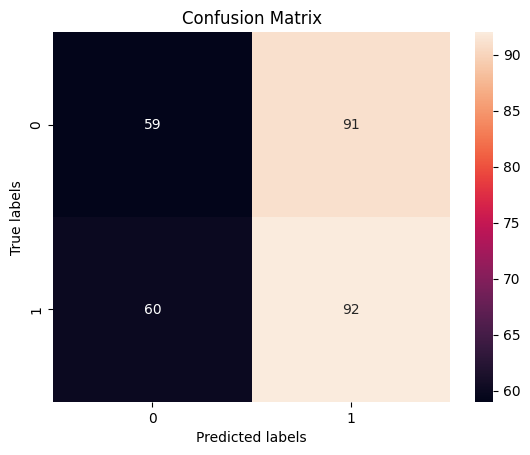

In [196]:
from sklearn.metrics import confusion_matrix
import pylab as pl
import seaborn as sns

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, ax = ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [197]:
import sklearn
sklearn.metrics.accuracy_score(y_test, y_pred)

0.5

Случайный лес плохо себя показал

In [164]:
# grid search
from sklearn.model_selection import StratifiedKFold
model = xgboost.XGBClassifier()
n_estimators = range(50, 400, 50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x_train, y_train)

In [165]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.873844 using {'n_estimators': 50}
-0.873844 (0.085095) with: {'n_estimators': 50}
-0.978324 (0.115135) with: {'n_estimators': 100}
-1.054729 (0.140362) with: {'n_estimators': 150}
-1.106638 (0.147771) with: {'n_estimators': 200}
-1.145415 (0.151239) with: {'n_estimators': 250}
-1.170224 (0.152049) with: {'n_estimators': 300}
-1.187856 (0.152488) with: {'n_estimators': 350}


In [166]:
max_depth = range(1, 11, 2)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best: -0.715799 using {'max_depth': 1}
-0.715799 (0.026810) with: {'max_depth': 1}
-0.832769 (0.049891) with: {'max_depth': 3}
-0.957880 (0.124204) with: {'max_depth': 5}
-1.018470 (0.096343) with: {'max_depth': 7}
-1.017201 (0.132639) with: {'max_depth': 9}


In [201]:
n_estimators = [50, 100, 150, 200]
max_depth = [1, 2, 4, 6, 8]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

[1, 2, 4, 6, 8]
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: -0.695807 using {'max_depth': 1, 'n_estimators': 50}
-0.695807 (0.018460) with: {'max_depth': 1, 'n_estimators': 50}
-0.707610 (0.028157) with: {'max_depth': 1, 'n_estimators': 100}
-0.714899 (0.033360) with: {'max_depth': 1, 'n_estimators': 150}
-0.719918 (0.036436) with: {'max_depth': 1, 'n_estimators': 200}
-0.723577 (0.038044) with: {'max_depth': 2, 'n_estimators': 50}
-0.753440 (0.056385) with: {'max_depth': 2, 'n_estimators': 100}
-0.786997 (0.065894) with: {'max_depth': 2, 'n_estimators': 150}
-0.808622 (0.072266) with: {'max_depth': 2, 'n_estimators': 200}
-0.823700 (0.058722) with: {'max_depth': 4, 'n_estimators': 50}
-0.925993 (0.073835) with: {'max_depth': 4, 'n_estimators': 100}
-1.028326 (0.098322) with: {'max_depth': 4, 'n_estimators': 150}
-1.113550 (0.123424) with: {'max_depth': 4, 'n_estimators': 200}
-0.886110 (0.085623) with: {'max_depth': 6, 'n_estimators': 50}
-1.022206 (0.127163) 

In [202]:
# делаем прогнозы на тестовой выборке
model = xgboost.XGBClassifier(n_estimators=50,max_depth=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# оцениваем предсказания
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 44.70%


Даже после оптимизации гиперпараметров XGBoost результаты неудовлетворительны